# **Import**

In [1]:
!git clone https://github.com/zuoxingdong/mazelab.git
%cd mazelab
!pip install -e .

Cloning into 'mazelab'...
remote: Enumerating objects: 328, done.
remote: Total 328 (delta 0), reused 0 (delta 0), pack-reused 328
Receiving objects: 100% (328/328), 11.77 MiB | 18.98 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/mazelab
Obtaining file:///content/mazelab
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mazelab


In [2]:
!pip install -r requirements.txt

In [3]:
!pip install gym

In [4]:
import numpy as np
import random
from mazelab import BaseMaze
from mazelab import Object
from mazelab import DeepMindColor as color

from mazelab import BaseEnv
from mazelab import VonNeumannMotion

from abc import ABC
from abc import abstractmethod

import gym
from gym.utils import seeding
from gym.spaces import Box
from gym.spaces import Discrete

import pygame
import collections

# **FUNCTIONS**

In [5]:
trash_cans = {'plastic': [(16,1),(18,27),(2,28)], 'paper': [(18,7),(18,26),(7,28)], 'general': [(15,12),(1,20)], 'edible': [(1,1),(11,6),(12,28)]}
fullness = {(16,1): 0, (18,27): 0, (2,28): 0, (18,7): 0, (18,26): 0, (7,28): 0, (15,12): 0, (1,20): 0, (1,1): 0, (11,6): 0, (12,28): 0}


def update_fullness(coords):
  fullness[coords] += 1


def is_full(coords):
  #string_coords = '(' + str(coords[0]) + ', ' + str(coords[1]) + ')'
  n = fullness[coords]
  if n == 3: return True
  else: return False


def random_closed(n):
  doors = [(13,3), (2,7), (9,7), (13,9), (14,21), (12,22), (7,22), (2,22), (5,26)]
  random_closed = random.sample(doors, n)
  return random_closed

def define_goals(trash_can):
  goals = []
  for i in trash_cans[trash_can]:
    if not is_full(i):
      goals.append(i)
  return goals


def generate_matrix(agent, goals, random_closed):
  x = np.array([[1, 1, 1, 1, 1, 1 ,1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 4, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 5, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1],
                [1, 1, 1, 1, 1, 1 ,1, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1 ,1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1],
                [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1, 0, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 7, 6, 0, 1],
                [1, 1, 1, 1, 1, 1 ,1, 1, 1, 1, 1, 1, 1, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=np.uint8)

  x[agent[0], agent[1]] = 2
  for i in goals:
    x[i[0], i[1]] = 8
  for i in random_closed:
    x[i[0], i[1]] = 9

  return x


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def plot(x, render_mode = "human", window_size_x=3000, window_size_y=2000):

  pygame.init()
  pygame.display.init()
  window = pygame.display.set_mode((window_size_x, window_size_y))

  canvas = pygame.Surface((window_size_y, window_size_x))
  canvas.fill((255, 255, 255))
  pix_square_size_x = (
      window_size_x / 30
  )  # The size of a single grid square in pixels
  pix_square_size_y = (
      window_size_y / 20
  )  # The size of a single grid square in pixels

  #print(pix_square_size_x, pix_square_size_y)

  i = 0
  for r in x:
    j = 0
    for c in r:
      #print(c)
      if c == 0:
        pygame.draw.rect(canvas, (255, 255, 255),
                          pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                          (pix_square_size_x, pix_square_size_y)))
      elif c == 1:
        pygame.draw.rect(canvas, (192, 192, 192),
                          pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                          (pix_square_size_x, pix_square_size_y)))
      elif c == 2:
        pygame.draw.rect(canvas, (255, 0, 0),
                          pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                          (pix_square_size_x-20, pix_square_size_y-20)))
      elif c == 3:
        pygame.draw.rect(canvas, (51, 175, 2),
                        pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                          (pix_square_size_x, pix_square_size_y)))
      elif c == 4:
        pygame.draw.ellipse(canvas, (97, 255, 34), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)))
        '''
        pygame.draw.rect(canvas, (97, 255, 34),
                        pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                          (pix_square_size_x, pix_square_size_y)))
        '''
      elif c == 5:
        pygame.draw.ellipse(canvas, (96, 96, 96), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)))

      elif c == 6:
        pygame.draw.ellipse(canvas, (0, 0, 255), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)))

      elif c == 7:
        pygame.draw.ellipse(canvas, (255, 190, 0), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)))

      elif c == 8:
        if (i,j) in trash_cans['plastic']:
          pygame.draw.ellipse(canvas, (0, 0, 255), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)))

        if (i,j) in trash_cans['paper']:
          pygame.draw.ellipse(canvas, (255, 190, 0), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)))

        if (i,j) in trash_cans['general']:
          pygame.draw.ellipse(canvas, (96, 96, 96), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)))

        if (i,j) in trash_cans['edible']:
          pygame.draw.ellipse(canvas, (97, 255, 34), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)))

        pygame.draw.ellipse(canvas, (255, 0, 0), ((int(pix_square_size_x)*i, int(pix_square_size_y)*j), (pix_square_size_x, pix_square_size_y)), width= 15)

      else:
        pygame.draw.rect(canvas, (153, 76, 0),
                        pygame.Rect((int(pix_square_size_x)*i, int(pix_square_size_y)*j),
                          (pix_square_size_x, pix_square_size_y)))
      #print(m[i][j])
      j+=1
    i+=1

  return np.array(pygame.surfarray.pixels3d(canvas))

In [7]:
class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape

    def make_objects(self):
        free = Object('free', 0, [255, 255, 255], False, np.stack(np.where(x == 0), axis=1))
        walls = Object('obstacle1', 1, [160, 160, 160], True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, [255, 0, 0], False, [])
        garden = Object('obstacle2', 1, [51, 175, 2], True, np.stack(np.where(x == 3), axis=1))
        green = Object('obstacle3', 0, [97, 255, 34], False, np.stack(np.where(x == 4), axis=1))
        black = Object('obstacle4', 0, [0, 0, 0], False, np.stack(np.where(x == 5), axis=1))
        blue = Object('obstacle5', 0, [0, 0, 255], False, np.stack(np.where(x == 6), axis=1))
        yellow = Object('obstacle6', 0, [255, 190, 0], False, np.stack(np.where(x == 7), axis=1))
        goal = Object('goal', 8, [255, 0, 0], False, [])
        door = Object('obstacle7', 1, [110, 89, 69], True, np.stack(np.where(x == 9), axis=1))

        return free, walls, agent, garden, green, black, blue, yellow, goal, door


class BaseEnv(gym.Env, ABC):
    metadata = {'render.modes': ['human', 'rgb_array'],
                'video.frames_per_second' : 3}
    reward_range = (-float('inf'), float('inf'))

    def __init__(self):
        self.viewer = None
        self.seed()

    @abstractmethod
    def step(self, action):
        pass

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def get_image(self):
        pass

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None


class Env(BaseEnv):
    def __init__(self):
        super().__init__()

        self.maze = Maze()
        self.motions = VonNeumannMotion()

        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))

        self.window = None

    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        #print(current_position,new_position)
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
            #print('------------------')

        if self._is_goal(new_position):
            #print('ARRIVATO AL GOAL!!')
            reward = +1000
            done = True
        elif not valid:
            reward = -100
            done = False
        else:
            reward = -0.1
            done = False
        return [current_position, new_position], reward, done, {}  #self.maze.to_value()

    def reset(self):
        start_idx = np.stack(np.where(x == 2), axis=1)
        goal_idx = np.stack(np.where(x == 8), axis=1)

        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        #print(start_idx, goal_idx)
        return self.maze.to_value(), start_idx, goal_idx

    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < 20 and position[1] < 30
        #print(self.maze.to_value()[position[0]][position[1]])
        if self.maze.to_value()[position[0]][position[1]] == 1:
          passable = False
        else: passable = True
        #passable = not self.maze.to_impassable()[position[0]][position[1]]
        #print(position, passable)
        return nonnegative and within_edge and passable

    def _is_goal(self, position):
        out = False
        #print(self.maze.objects.goal.positions)
        for pos in self.maze.objects.goal.positions:
            #print(pos)
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out

    def get_image(self):
        return self.maze.to_rgb()


# **TRAINING AGENT**

[(9, 7), (13, 9), (13, 3)]
[(18, 7), (18, 26), (7, 28)]
[[1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1]
 [1 4 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 5 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0 6 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 0 0 0 0 0 0 8 1]
 [1 0 0 0 0 0 0 1 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 9 0 0 1 3 3 3 3 3 3 3 3 1 0 0 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1]
 [1 1 1 9 1 1 1 1 1 9 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1]

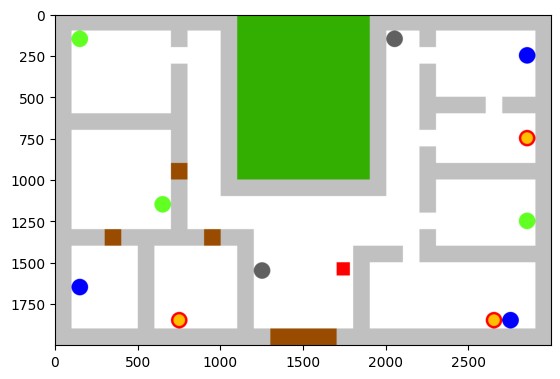

In [76]:
import matplotlib.pyplot as plt

goals = define_goals('paper')
doors_closed = random_closed(3)
print(doors_closed)
print(goals)

x = generate_matrix((15,17), goals, doors_closed)
print(x)

img = plot(x, "nn", window_size_x=3000, window_size_y=2000)
plt.imshow(img)

In [77]:
gym.envs.register(id='env', entry_point=Env, max_episode_steps=200)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment env
  logger.warn(f"Overriding environment {spec.id}")


In [78]:
env = gym.make('env')
#env.reset()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (20, 30)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [79]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(4)
State Space Box(0, 10, (20, 30), uint8)


In [80]:
q_table = np.zeros([600, 4])

matrix = [[row * 30 + col for col in range(30)] for row in range(20)]

"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
eps_init = 0.5
eps_min = 0.05
eps_decay = 0.9994

epochs = 1000


# Generate exponentially decaying epsilon values
epsilons = [eps_init * np.exp(-eps_decay * i) for i in range(epochs)]

#print(epsilons)

best_steps  = []

for i in range(1, 1001):
    world, agent, goal = env.reset()

    state = matrix[agent[0][0]][agent[0][1]]
    goal = matrix[goal[0][0]][goal[0][1]]

    #print(state, goal)

    epochs, penalties, reward, = 0, 0, 0
    done = False

    steps = []
    steps.append(state)

    while not done:
        if random.uniform(0, 1) < epsilons[i-1]:
            action = env.action_space.sample() # Explore action space
            #print(state, action)
        else:
            action = np.argmax(q_table[state]) # Exploit learned values
            #print(state, 'OLD'+ str(action))

        pos, reward, done, info = env.step(action)

        old_state = matrix[pos[0][0]][pos[0][1]]
        new_state = matrix[pos[1][0]][pos[1][1]]
        #print(old_state, new_state)

        steps.append(new_state)

        old_value = q_table[old_state, action]
        #print(old_value)
        next_max = np.max(q_table[new_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[old_state, action] = new_value

        if reward == -10:
            penalties += 1

        state = new_state
        epochs += 1

    if i == 1:
      best_steps = steps
      print(best_steps)
    else:
      if len(steps) < len(best_steps):
        best_steps = steps
        print(best_steps)

print("Training finished.\n")


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'tuple'>
  logger.warn(
/usr/local/lib

[467, 497, 467, 437, 407, 377, 347, 346, 316, 376, 346, 345, 315, 315, 346, 376, 406, 405, 375, 345, 375, 405, 375, 345, 344, 374, 344, 343, 313, 342, 312, 312, 343, 344, 314, 314, 314, 314, 374, 404, 374, 373, 343, 373, 403, 373, 372, 342, 372, 373, 374, 375, 374, 344, 345, 375, 376, 346, 347, 317, 377, 378, 348, 318, 349, 319, 319, 319, 350, 320, 321, 291, 261, 260, 259, 230, 231, 201, 200, 170, 171, 141, 111, 81, 82, 52, 112, 52, 52, 81, 51, 21, 21, 50, 80, 50, 20, 20, 51, 81, 111, 81, 80, 81, 80, 110, 80, 79, 50, 49, 80, 110, 140, 110, 80, 110, 111, 141, 142, 142, 111, 110, 109, 111, 112, 81, 51, 52, 21, 21, 21, 21, 21, 81, 51, 50, 80, 81, 80, 50, 20, 20, 51, 52, 21, 81, 111, 110, 140, 141, 111, 110, 111, 112, 141, 171, 172, 170, 140, 170, 140, 170, 200, 230, 200, 199, 230, 260, 290, 289, 260, 259, 290, 320, 290, 291, 261, 231, 261, 291, 321, 291, 290, 291, 290, 260, 261, 262, 231, 230, 229, 200, 201, 202, 171, 170, 169, 200, 170, 200, 230]
[467, 466, 436, 406, 405, 375, 345, 344, 

In [81]:
def find_value(matrix, value):
    rows = len(matrix)
    cols = len(matrix[0])

    for i in range(rows):
        for j in range(cols):
            if matrix[i][j] == value:
                return i, j

    # Value not found
    return -1, -1

In [82]:
i,j = find_value(matrix, best_steps[-1])

print(i,j)

update_fullness((i,j))
print(fullness)


18 26
{(16, 1): 1, (18, 27): 1, (2, 28): 0, (18, 7): 0, (18, 26): 2, (7, 28): 0, (15, 12): 0, (1, 20): 0, (1, 1): 0, (11, 6): 0, (12, 28): 1}


[467, 437, 407, 408, 409, 410, 411, 441, 471, 472, 502, 503, 533, 563, 564, 565, 566]


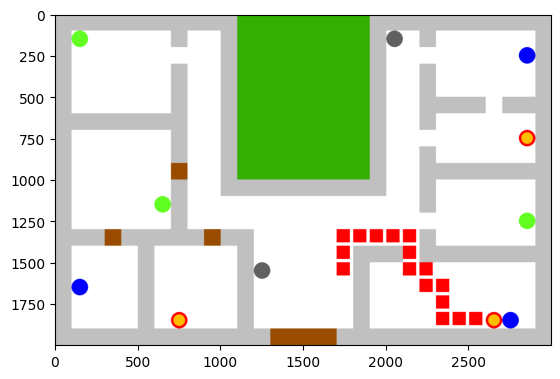

In [83]:
print(best_steps)

for s in best_steps[:-1]:
  i,j = find_value(matrix, s)
  x[i,j] = 2

img = plot(x, "nn", window_size_x=3000, window_size_y=2000)
plt.imshow(img)


**Added part by Leo**
(how to deal with plan generated by the planner and visualize it!)

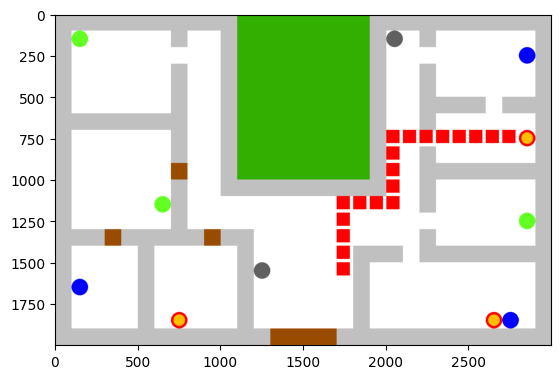

In [84]:
x = generate_matrix((15,17), goals, doors_closed) # I added this to regenerate the map each time I want

# example of plan returned by the planner --> is a "string" composed by a first part that is the actual plan and then the updated dict representing the fullness of the bins!
ris = "[467, 437, 407, 377, 347, 348, 349, 350, 320, 290, 260, 230, 231, 233, 234, 235, 236, 237, 238] - {(16, 1): 0, (18, 27): 0, (2, 28): 0, (18, 7): 0, (18, 26): 3, (7, 28): 1, (15, 12): 0, (1, 20): 0, (1, 1): 0, (11, 6): 0, (12, 28): 0}"
cells_plan, bins_fullness = ris.split(" - ")
cells_plan = [int(e) for e in cells_plan[1:-1].split(", ")]

# the fact is that the plan generated by the planner doesn't consider the cells occupied by doors,
# so to display correctly the path to reach the goal we need to overcome this little problem...
cells_adj_doors = [363, 423, 66, 68, 276, 278, 429, 369, 471, 411, 383, 381, 233, 231, 83, 81, 206, 146]
cells_adj_doors = set(cells_adj_doors)
states2cells_doors = {363 : 393, 423 : 393, 66 : 67, 68 : 67, 276 : 277, 278 : 277, 429 : 399, 369 : 399, 471 : 441, 411 : 441, 381 : 382, 383 : 382, 233 : 232, 231 : 232, 83 : 82, 81 : 82, 206 : 176, 146 : 176}

new_plan = []
for i in range(len(cells_plan)):
    new_plan.append(cells_plan[i])
    if cells_plan[i] in cells_adj_doors:
        if cells_plan[i+1] in cells_adj_doors:
            new_plan.append(states2cells_doors[cells_plan[i]])
    else:
        continue

best_steps = new_plan
for s in best_steps[:-1]:
  i,j = find_value(matrix, s)
  x[i,j] = 2

img = plot(x, "nn", window_size_x=3000, window_size_y=2000)
plt.imshow(img)

The plan is different because in my planner I set the fullness level of the nearest bin to 3! :)